# Lab Segmentation 1

In [25]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
pip install pydicom

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.4 MB 3.0 MB/s eta 0:00:01
   ----------------- ---------------------- 1.0/2.4 MB 2.8 MB/s eta 0:00:01
   ----------------- ---------------------- 1.0/2.4 MB 2.8 MB/s eta 0:00:01
   ---------------------- ----------------- 1.3/2.4 MB 1.5 MB/s eta 0:00:01
   ---------------------- ----------------- 1.3/2.4 MB 1.5 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.4 MB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pydicom
from pydicom.data import get_testdata_file
import commonfunctions as cf
import cv2
import numpy as np
import matplotlib.pyplot as plt


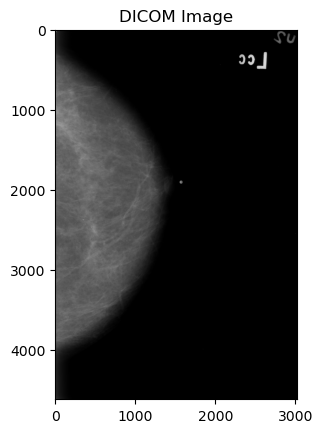

In [26]:

import matplotlib.pyplot as plt
dcm = pydicom.dcmread("images/1-1.dcm")

# Extract pixel array
img = dcm.pixel_array

show_images([img], ['DICOM Image'])


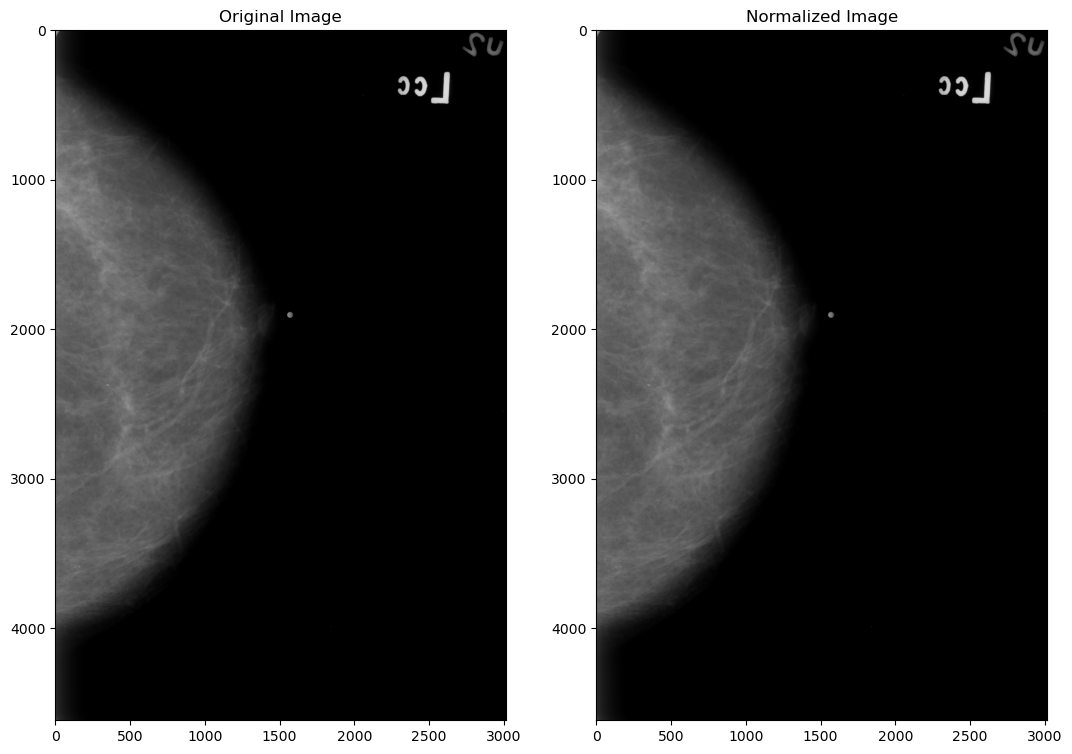

In [30]:
# Normalize to 0–255
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
img_uint8 = np.uint8(img_norm)
show_images([img, img_uint8], ['Original Image', 'Normalized Image'])

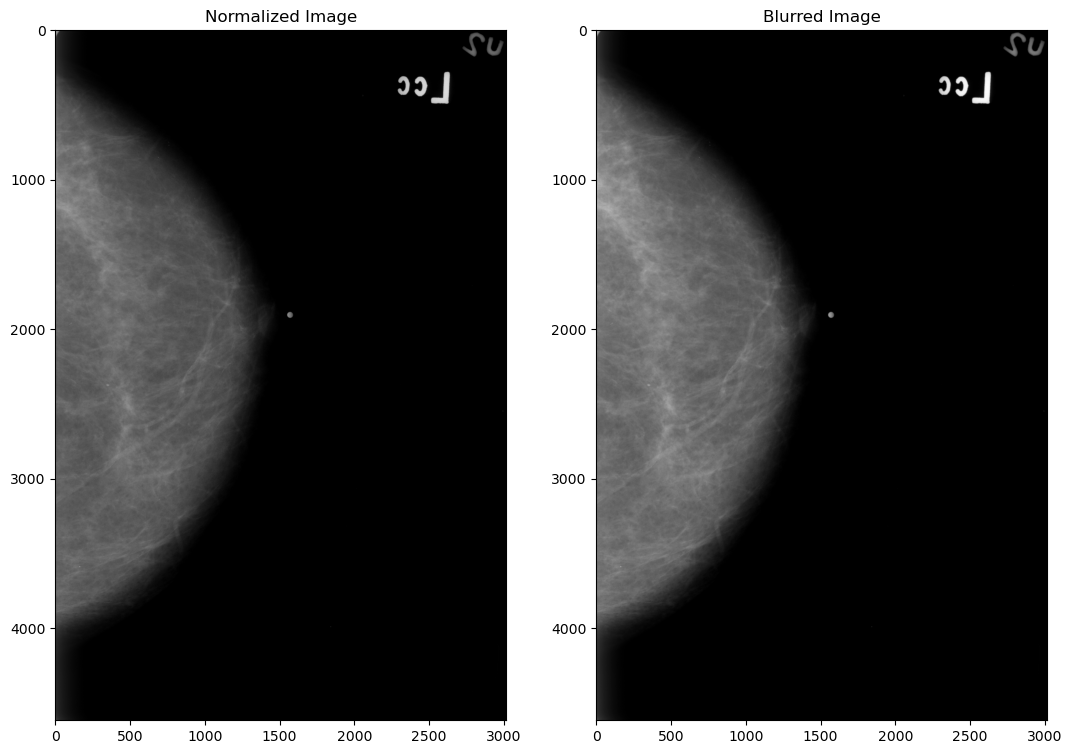

In [ ]:

img_blur = cv2.GaussianBlur(img_uint8, (5, 5), 0)
show_images([img_uint8, img_blur], ['Normalized Image', 'Blurred Image'])

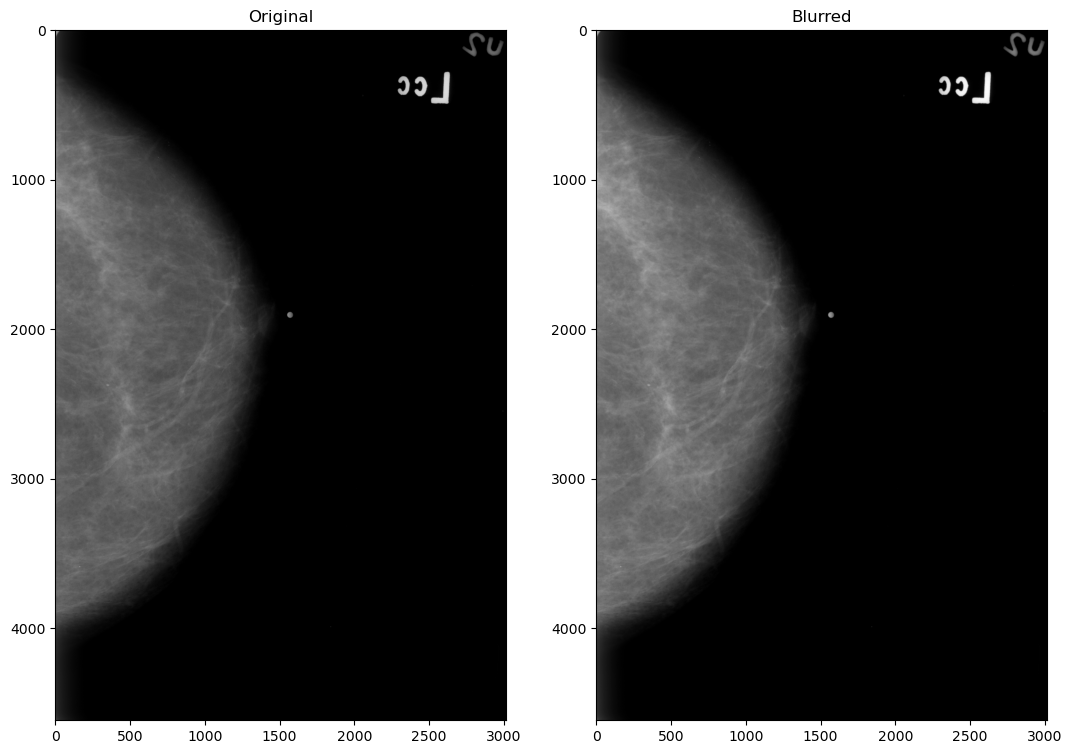

In [15]:
show_images([img_uint8, img_blur], ['Original', 'Blurred'])

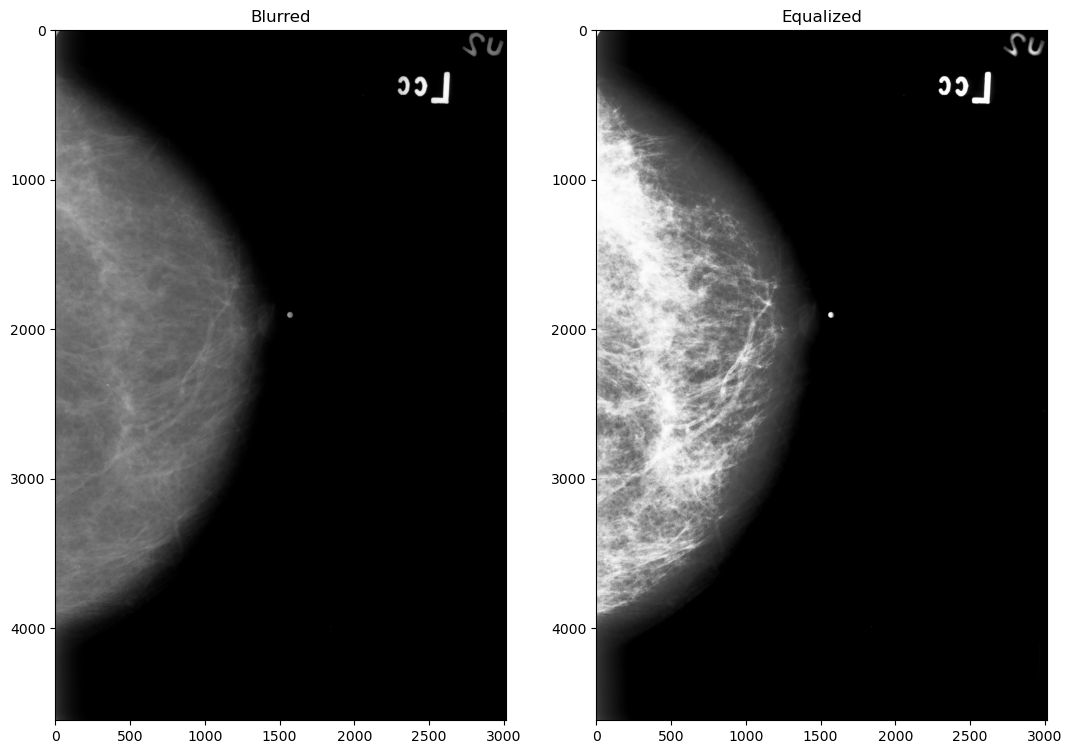

In [16]:
img_eq = cv2.equalizeHist(img_blur)
show_images([img_blur, img_eq], ['Blurred', 'Equalized'])

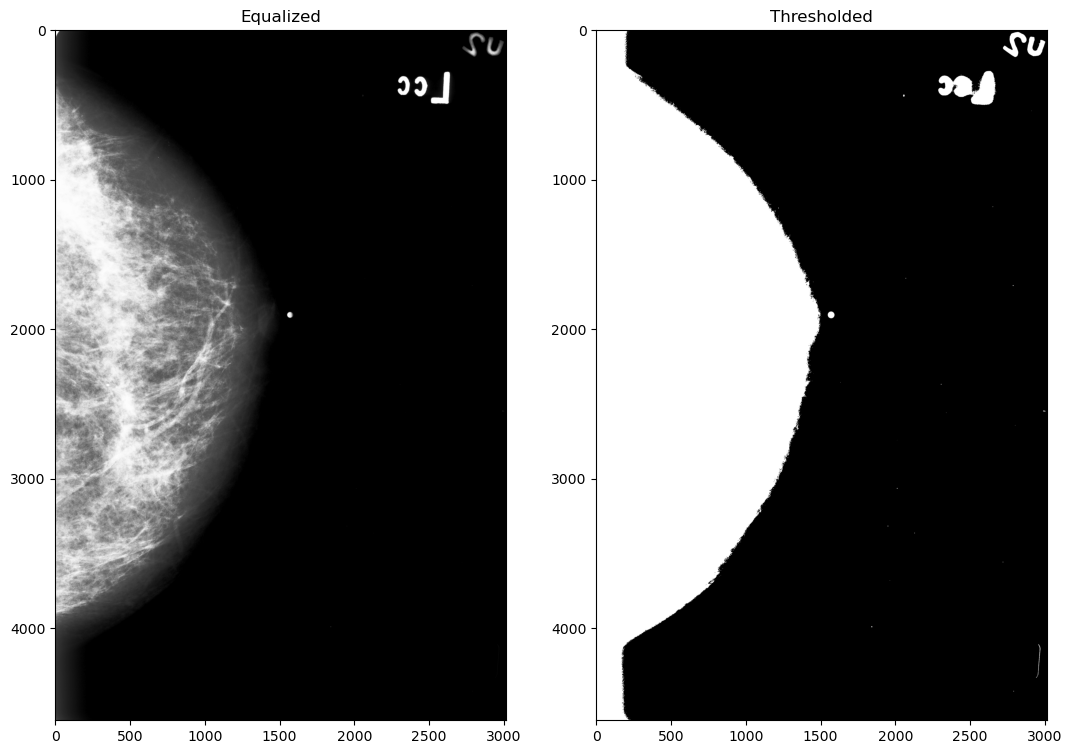

In [17]:
_, thresh = cv2.threshold(img_eq, 5, 255, cv2.THRESH_BINARY)
show_images([img_eq, thresh], ['Equalized', 'Thresholded'])

In [18]:
th = thresh.copy()
th = cv2.threshold(th, 127, 255, cv2.THRESH_BINARY)[1]

# Connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th, connectivity=8)

# stats = [label, x, y, width, height, area]

# Find the largest connected component (ignore background label 0)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

# Create mask of only the largest component
clean_mask = np.zeros_like(th)
clean_mask[labels == largest_label] = 255

# (Optional) smooth mask edges
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel)

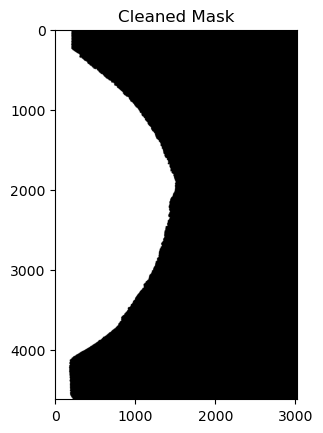

In [19]:
show_images([clean_mask], ['Cleaned Mask'])

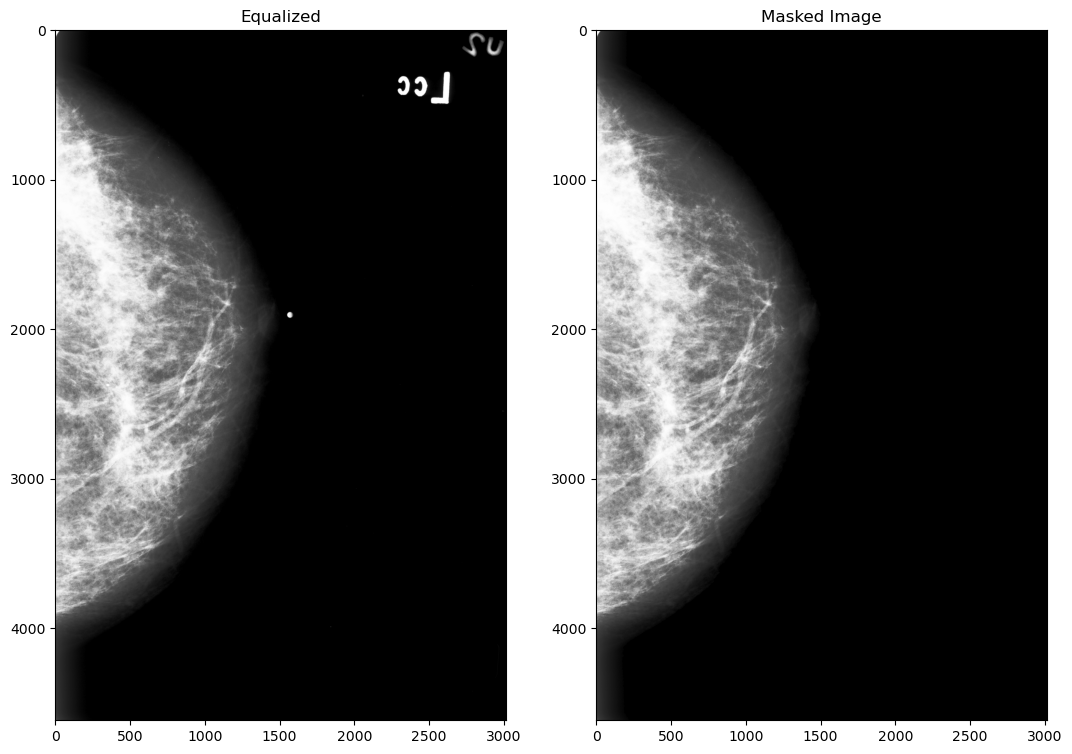

In [20]:
# Ensure clean_mask is 0/255
masked_img = cv2.bitwise_and(img_eq, img_eq, mask=clean_mask)
show_images([img_eq, masked_img], ['Equalized', 'Masked Image'])

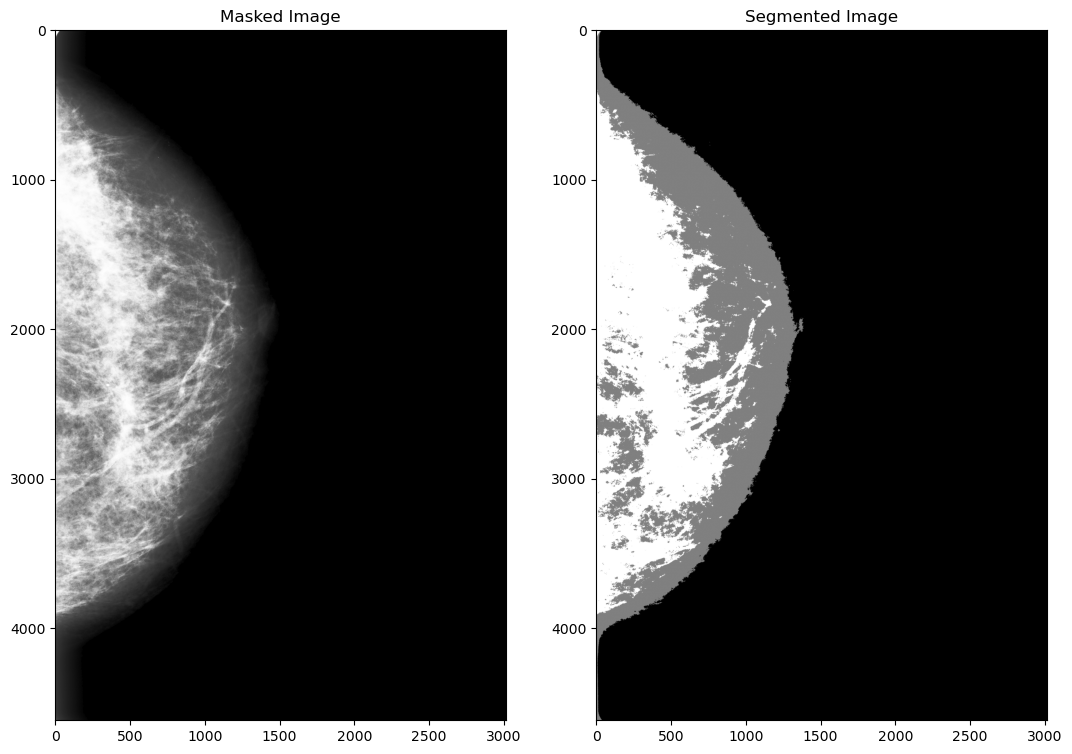

In [21]:
pixel_values = masked_img.reshape((-1, 1))
pixel_values = pixel_values.astype(np.float32)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
K = 3  # works best for mammograms

_, labels, centers = cv2.kmeans(
    pixel_values,
    K,
    None,
    criteria,
    10,
    cv2.KMEANS_PP_CENTERS
)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape(masked_img.shape)
show_images([masked_img, segmented_image], ['Masked Image', 'Segmented Image'])

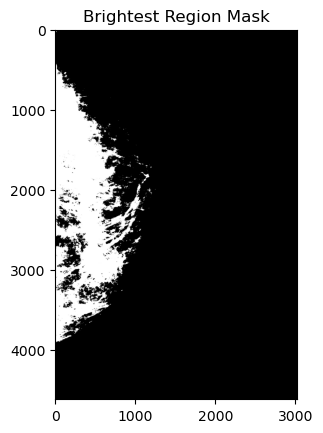

In [22]:
#exctract brightest region
brightest_cluster = np.argmax(centers)
brightest_mask = np.zeros_like(labels, dtype=np.uint8)
brightest_mask[labels.flatten() == brightest_cluster] = 255
brightest_mask = brightest_mask.reshape(masked_img.shape)
show_images([brightest_mask], ['Brightest Region Mask'])

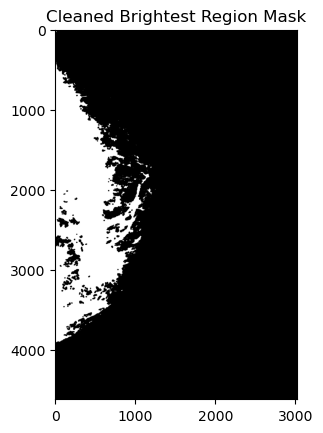

In [ ]:
#clean the mass masked_img
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
clean_brightest_mask = cv2.morphologyEx(brightest_mask, cv2.MORPH_CLOSE, kernel)
show_images([clean_brightest_mask], ['Cleaned Brightest Region Mask'])

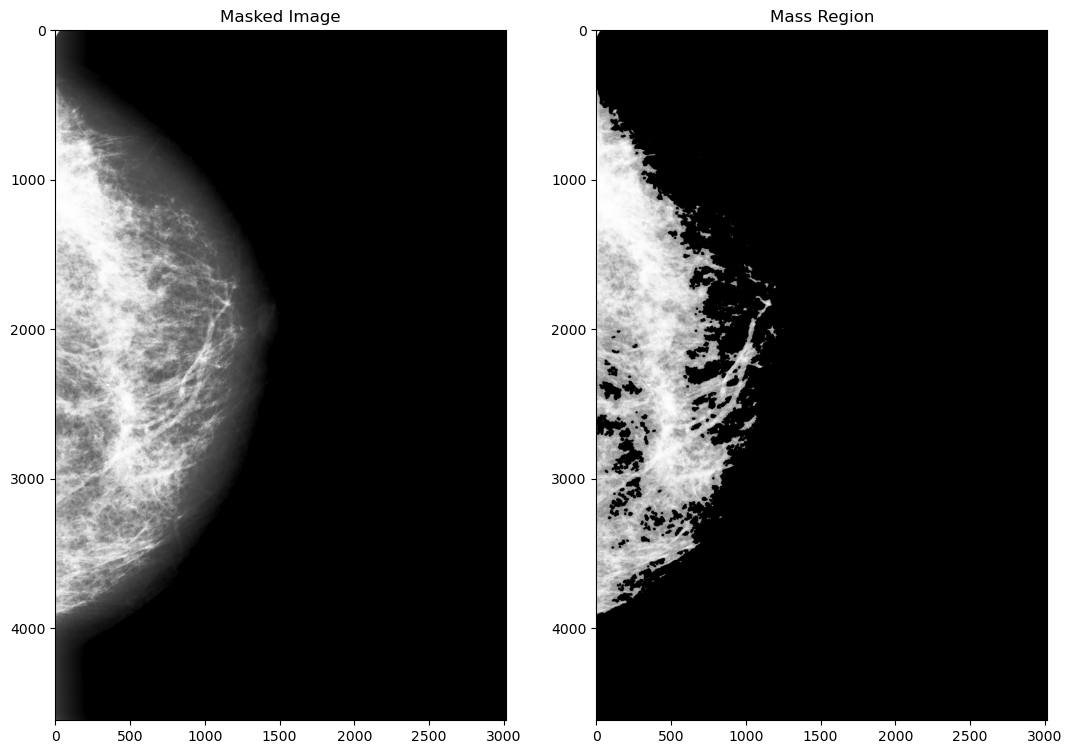

In [ ]:
mass_region = cv2.bitwise_and(masked_img, masked_img, mask=clean_brightest_mask)
show_images([masked_img, mass_region], ['Masked Image', 'Mass Region'])